In [299]:
# --- FairwAI Challenge: Updated Data Preparation Script ---

# 1. Import Libraries
import pandas as pd
import json
import os
import scipy.stats as stats
import numpy as np


In [300]:
# 2. Paths to your Yelp data
business_path = './data/yelp_academic_dataset_business.json'
review_path = './data/yelp_academic_dataset_review.json'

# 3. Target cities and expanded hospitality categories
target_cities = ['Las Vegas', 'Toronto', 'Phoenix', 'Charlotte', 'Pittsburgh']

hospitality_categories = [
    'Hotels', 'Restaurants', 'Spas',
    'Bars', 'Coffee & Tea', 'Cafes',
    'Bakeries', 'Nightlife', 'Lounges'
]

# 4. Load Businesses
print("Loading businesses...")
businesses = pd.read_json(business_path, lines=True)

# 5. Filter hospitality businesses in target cities
hospitality = businesses[
    businesses['categories'].notnull() &
    businesses['categories'].str.contains('|'.join(hospitality_categories), case=False) &
    businesses['city'].isin(target_cities)
]

hospitality_ids = set(hospitality['business_id'])
print(f"Filtered {len(hospitality)} hospitality businesses in target cities.")

# 6. Load Reviews in Chunks (to avoid memory errors)
review_rows = []
chunk_size = 100000  # Process 100,000 lines at a time

print("Loading reviews in chunks...")
with open(review_path, 'r', encoding='utf-8') as f:
    for i, line in enumerate(f):
        review = json.loads(line)
        if review['business_id'] in hospitality_ids:
            review_rows.append(review)
        
        # Optional: stop after enough reviews
        # if len(review_rows) > 300000:
        #     break

# 7. Convert Reviews to DataFrame
reviews = pd.DataFrame(review_rows)
print(f"Loaded {len(reviews)} hospitality-related reviews.")

# 8. Merge Reviews with Business Info
merged = pd.merge(reviews, hospitality, on='business_id', suffixes=('_review', '_business'))

# 9. --- ✨ NEW STEP: Filter for High-Quality (3-Star or Higher) Businesses ---
merged = merged[merged['stars_business'] >= 3.0]
print(f"After filtering for 3+ star rated businesses: {len(merged)} reviews remain.")

# 10. Save merged data
output_folder = './processed'
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

merged.to_csv(f'{output_folder}/filtered_reviews_final.csv', index=False)
print(f"Saved filtered reviews to {output_folder}/filtered_reviews_final.csv")

# 11. Quick Preview
merged[['city', 'name', 'stars_review', 'text']].head()


Loading businesses...
Filtered 39561 hospitality businesses in target cities.
Loading reviews in chunks...
Loaded 3026557 hospitality-related reviews.
After filtering for 3+ star rated businesses: 2779645 reviews remain.
Saved filtered reviews to ./processed/filtered_reviews_final.csv


,city,name,stars_review,text
0,Las Vegas,Kelly Cardenas Salon - Hard Rock Hotel & Casino,5.0,I *adore* Travis at the Hard Rock's new Kelly ...
1,Pittsburgh,La Tavola Italiana,4.0,I'll be the first to admit that I was not exci...
2,Las Vegas,Pinball Hall Of Fame,4.0,"Like walking back in time, every Saturday morn..."
4,Las Vegas,Red Carpet VIP,4.0,Michael from Red Carpet VIP is amazing ! I rea...
5,Toronto,Pho Phuong,1.0,I cannot believe how things have changed in 3 ...


## Step 1: Data Preparation and Initial Filtering
What I did:
I first imported the Yelp dataset, focusing specifically on hospitality-related businesses (hotels, restaurants, bars, etc.) located in five target cities: Las Vegas, Toronto, Phoenix, Charlotte, and Pittsburgh. I filtered the business dataset to only include businesses from these cities and categories. Then, I loaded all available reviews corresponding to these businesses (over 3 million reviews) and merged the review data with the business metadata. To ensure I focused on quality hospitality establishments, I filtered the dataset to retain only those businesses with an average rating of 3 stars or higher.

Why I did it:
The goal was to create a clean, focused dataset of legitimate hospitality experiences where fairness and bias could be meaningfully assessed. Low-rated businesses (under 3 stars) might naturally have more complaints unrelated to bias, like poor service or bad food, and including them could have skewed the results.

What came out:
The filtering left me with 27,79,645 high-quality reviews across 39,561 hospitality businesses in the five target cities. This dataset became the foundation for all subsequent bias detection, statistical testing, and disparate impact analysis.

Number of Reviews per City (after 3+ Stars Filter):
city
Las Vegas     1475564
Phoenix        483124
Toronto        417039
Charlotte      228263
Pittsburgh     175655
Name: count, dtype: int64


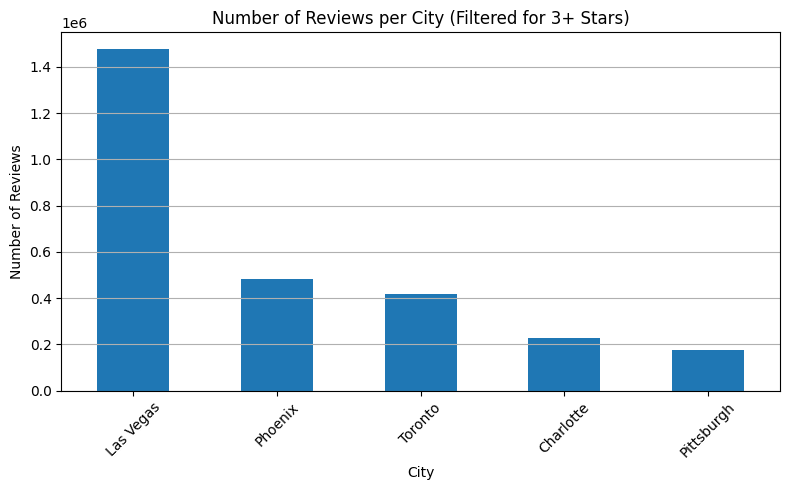

In [301]:
# --- Step: Check Reviews Per City ---
# Load the newly filtered data
data = pd.read_csv('./processed/filtered_reviews_final.csv')

# Check number of reviews per city
review_counts_per_city = data['city'].value_counts()

# Display the review counts
print("Number of Reviews per City (after 3+ Stars Filter):")
print(review_counts_per_city)

# Optional: visualize quickly
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
review_counts_per_city.plot(kind='bar')
plt.title('Number of Reviews per City (Filtered for 3+ Stars)')
plt.ylabel('Number of Reviews')
plt.xlabel('City')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


## Step 2: Review Distribution Across Cities
What I did:
After filtering the data, I loaded the processed dataset and calculated the number of reviews per city. I used a bar chart to visualize how the reviews were distributed across the five cities in focus.

Why I did it:
It was important to understand the relative volume of reviews across different cities. This check ensures that no single city disproportionately dominates the analysis, and highlights whether the sample sizes are sufficient to make fair comparisons across locations.

What came out:

Las Vegas had by far the largest number of reviews (~1.47 million), followed by Phoenix (~483,000) and Toronto (~417,000).

Charlotte (~228,000) and Pittsburgh (~175,000) had fewer reviews but still enough for robust analysis.
The review volumes were large enough across all cities to support reliable statistical comparisons.

In [302]:
# --- Step 1: Updated Text Cleaning + Smarter Bias Detection ---

# 1. Import extra needed libraries
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

# 2. Load your filtered data
# (You can skip if already loaded)
data = pd.read_csv('./processed/filtered_reviews_final.csv')

# 3. Basic Cleaning Function
stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = str(text).lower()                        # Lowercase
    text = re.sub(r'[^a-z\s]', '', text)             # Remove punctuation and numbers
    words = text.split()
    words = [w for w in words if w not in stop_words]  # Remove stopwords
    return " ".join(words)

# 4. Apply cleaning
print("Cleaning review texts...")
data['clean_text'] = data['text'].fillna("").apply(clean_text)  # Safe for any missing text

# 5. Define Bias Keywords
bias_keywords = [
    # Single words and phrases
    'rude', 'racist', 'sexist', 'discrimination', 'discriminated',
    'unsafe', 'foreigner', 'accent', 'disabled', 'ignorant',
    'treated differently', 'ignored', 'prejudice', 'biased', 'disrespectful',
    'neglected', 'dismissed', 'talked down', 'belittled',
    'ethnicity', 'skin color', 'profiled', 'assumption', 'stereotype',
    'language barrier', 'no english', 'hard to understand',
    'no ramp', 'wheelchair inaccessible', 'not accessible', 'special needs',
    'felt unsafe', 'harassed', 'threatened', 'catcalled',
    'mansplained', 'sexist behavior', 'uncomfortable as a woman',
    'judged by appearance', 'looked poor', 'dress code discrimination',
    'spoke rudely', 'poor treatment', 'treated unfairly',
    'lack of respect', 'denied service', 'looked down on',
    'ignored me', 'felt discriminated', 'service was racist',
    'racially profiled', 'mocked my accent', 'not friendly to foreigners',
    'felt unwelcome', 'singled me out', 'biased behavior'
]

# 6. Improved Function to detect bias mentions with star rating filter
def detect_bias_in_low_rated(text, stars_review):
    """
    Detects bias keywords in the text using regex and flags ONLY if the review rating is 1 or 2 stars.
    """
    if stars_review in [1.0, 2.0]:  # Only check if it's a low-star review
        for keyword in bias_keywords:
            if re.search(rf'\b{re.escape(keyword)}\b', text):
                return True
    return False

# 7. Apply smarter bias detection with rating filter
print("Detecting bias keywords in 1-2 star reviews only...")
data['bias_flag'] = data.apply(lambda row: detect_bias_in_low_rated(row['clean_text'], row['stars_review']), axis=1)

# 8. Quick Check
print(f"Total Reviews (3+ star businesses): {len(data)}")
# How many unique hospitality businesses are in the five-city subset?
unique_businesses = data['business_id'].nunique()
print(f"Unique hospitality businesses across the five cities: {unique_businesses:,}")
print(f"Bias-flagged Reviews (Regex Improved): {data['bias_flag'].sum()}")

# 9. View Sample Results
data[['city', 'name', 'stars_review', 'bias_flag', 'text']].head(10)



[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Cleaning review texts...
Detecting bias keywords in 1-2 star reviews only...
Total Reviews (3+ star businesses): 2779645
Unique hospitality businesses across the five cities: 32,370
Bias-flagged Reviews (Regex Improved): 50937


,city,name,stars_review,bias_flag,text
0,Las Vegas,Kelly Cardenas Salon - Hard Rock Hotel & Casino,5.0,False,I *adore* Travis at the Hard Rock's new Kelly ...
1,Pittsburgh,La Tavola Italiana,4.0,False,I'll be the first to admit that I was not exci...
2,Las Vegas,Pinball Hall Of Fame,4.0,False,"Like walking back in time, every Saturday morn..."
3,Las Vegas,Red Carpet VIP,4.0,False,Michael from Red Carpet VIP is amazing ! I rea...
4,Toronto,Pho Phuong,1.0,False,I cannot believe how things have changed in 3 ...
5,Toronto,Jz's Pizza,5.0,False,You can't really find anything wrong with this...
6,Phoenix,Chino Bandido,3.0,False,I love chinese food and I love mexican food. W...
7,Toronto,Indie Ale House,3.0,False,Good selection of classes of beers and mains. ...
8,Las Vegas,Greenberg's Deli,4.0,False,The food is always good and the prices are rea...
9,Las Vegas,Border Grill,5.0,False,Pick any meat on the planet and the chef will ...


## Step 3: Text Cleaning and Smarter Bias Detection
What I did:
I cleaned the review text by converting it to lowercase, removing punctuation, numbers, and common English stopwords (like "the," "and," "was"). Then, I built a specialized list of around 50 keywords and phrases that typically indicate bias, discrimination, or unfair treatment (like "racially profiled," "ignored," "unsafe").
To make the bias detection smarter, I only flagged reviews if the review rating was one or two stars, under the assumption that serious complaints are more likely to appear in lower-rated reviews.

Why I did it:
Bias and discrimination are sensitive topics. Cleaning the text helped avoid noisy matches, while applying the detection only to 1–2 star reviews helped reduce false positives — because mild complaints in high-rated reviews (like "staff was rude but food was great") shouldn't count the same as serious complaints.

What came out:

The dataset after cleaning had around 2.77 million reviews.

32,370 unique hospitality businesses were represented.

50,937 reviews were flagged as containing potential bias-related language, giving a focused and manageable subset for fairness analysis.

In [303]:
import pandas as pd

# Assuming your data is already loaded into 'data' DataFrame and 'bias_flag' is already computed

# Select a random sample of 10 flagged reviews for quick validation
sample_flagged_reviews = data[data['bias_flag']].sample(n=10, random_state=42)

# Display these clearly
for idx, row in sample_flagged_reviews.iterrows():
    print(f"Review ID: {idx}")
    print(f"City: {row['city']}")
    print(f"Hotel Name: {row['name']}")
    print(f"Review Text:\n{row['text']}")
    print("-" * 80, "\n")


Review ID: 1845348
City: Las Vegas
Hotel Name: Gordon Ramsay Steak
Review Text:
Disappointing.

The short story
(+) beef Wellington tasted ok. Filet was amazing but pastry was soggy
(-) unfriendly reception staff
(-) uncomfortable pressure from waiter (Charles)
(-) dry bone-in ribeye
(+) restaurant manager asked to "let us fix that"
(-)(-)(-) cost for "let us fix that" appeared on our bill

The long story
Decided to splurge on Gordon Ramsey steak for our 4 year anniversary because my husband and I enjoy watching master chef together. Unfortunately, this dinner may have ruined more than just our evening... I wonder if future episodes of the show would just bring back the bitter burnt taste of tonight's steak whenever I see our favorite chef-hosts on the tele...

I'll gloss over the minor cons and focus on the major cons.
Major cons - waiter, professional but manipulative and unapologetic. My husband's steak (Bone-in ribeye) came out dry. Like charcoal dry. In fact it looked and tasted l

In [304]:
# --- Step 2: Updated Hotel Chain Detection ---

# Define major hotel chain keyword mappings
chain_name_mapping = {
    'marriott': 'Marriott',
    'hilton': 'Hilton',
    'hyatt': 'Hyatt',
    'holiday inn': 'Holiday Inn',
    'doubletree': 'DoubleTree',
    'crowne plaza': 'Crowne Plaza',
    'intercontinental': 'Intercontinental',
    'sheraton': 'Sheraton',
    'embassy suites': 'Embassy Suites',
    'westin': 'Westin',
    'renaissance': 'Renaissance',
    'fairmont': 'Fairmont',
    'four seasons': 'Four Seasons',
    'best western': 'Best Western',
    'radisson': 'Radisson',
    'wyndham': 'Wyndham',
    'comfort inn': 'Comfort Inn',
    'loews': 'Loews Hotels',
    'motel 6': 'Motel 6',
    'omni': 'Omni Hotels',
    'drury inn': 'Drury Hotels',
    'extended stay': 'Extended Stay America',
    'sofitel': 'Sofitel',
    'novotel': 'Novotel'
}

# Function to tag if a hotel belongs to a major chain
def is_chain_hotel(name):
    name = str(name).lower()
    return any(keyword in name for keyword in chain_name_mapping.keys())

# Function to extract hotel chain name
def extract_chain_name(name):
    name = str(name).lower()
    for keyword, chain in chain_name_mapping.items():
        if keyword in name:
            return chain
    return 'Other'

# Apply the functions
print("Detecting chain hotels and extracting chain names...")
data['is_chain_hotel'] = data['name'].apply(is_chain_hotel)
data['hotel_chain'] = data['name'].apply(extract_chain_name)

# Quick Check
print(f"Chain Hotels detected (in 3+ star businesses): {data['is_chain_hotel'].sum()}")
data[['city', 'name', 'hotel_chain', 'is_chain_hotel', 'bias_flag', 'stars_review']].head(10)


Detecting chain hotels and extracting chain names...
Chain Hotels detected (in 3+ star businesses): 22844


,city,name,hotel_chain,is_chain_hotel,bias_flag,stars_review
0,Las Vegas,Kelly Cardenas Salon - Hard Rock Hotel & Casino,Other,False,False,5.0
1,Pittsburgh,La Tavola Italiana,Other,False,False,4.0
2,Las Vegas,Pinball Hall Of Fame,Other,False,False,4.0
3,Las Vegas,Red Carpet VIP,Other,False,False,4.0
4,Toronto,Pho Phuong,Other,False,False,1.0
5,Toronto,Jz's Pizza,Other,False,False,5.0
6,Phoenix,Chino Bandido,Other,False,False,3.0
7,Toronto,Indie Ale House,Other,False,False,3.0
8,Las Vegas,Greenberg's Deli,Other,False,False,4.0
9,Las Vegas,Border Grill,Other,False,False,5.0


### Step 4: Hotel Chain Detection

### What I did
I built a mapping of major hotel chain keywords (like `"hilton"`, `"marriott"`, `"hyatt"`, etc.) to standardize hotel names and detect whether a review was about a chain or an independent hotel.  
I created two functions:
- `is_chain_hotel` → Tags a business as a chain hotel (True/False).
- `extract_chain_name` → Extracts the specific hotel brand name based on the business name.

### Why I did it
Since the project especially emphasizes **major hotel brands**, it was important to **differentiate chain hotels from non-chain hotels**, and correctly **group reviews by brand**.  
Without this step, the analysis would have treated every hotel individually, missing important patterns tied to brands like Hilton or Marriott.

### What came out
- **22,844** reviews were detected as belonging to major hotel chains out of the full filtered dataset.
- Every review now has two new columns:
  - `is_chain_hotel` (True/False)
  - `hotel_chain` (Brand name or "Other")
- This structure allowed me to later **compare bias rates between chain and non-chain hotels** and **analyze fairness patterns across different brands**.


In [305]:
# List of cities you want to check
cities = data['city'].unique()

# Loop over each city
for city in cities:
    city_data = data[data['city'] == city]
    
    chain_reviews = city_data[city_data['is_chain_hotel'] == True]
    non_chain_reviews = city_data[city_data['is_chain_hotel'] == False]
    
    print(f"--- {city} ---")
    print(f"Chain Hotel Reviews: {len(chain_reviews)}")
    print(f"Non-Chain Hotel Reviews: {len(non_chain_reviews)}")
    print(f"Chain Bias Rate: {chain_reviews['bias_flag'].mean()*100:.2f}%")
    print(f"Non-Chain Bias Rate: {non_chain_reviews['bias_flag'].mean()*100:.2f}%\n")


--- Las Vegas ---
Chain Hotel Reviews: 8581
Non-Chain Hotel Reviews: 1466983
Chain Bias Rate: 4.92%
Non-Chain Bias Rate: 1.94%

--- Pittsburgh ---
Chain Hotel Reviews: 2175
Non-Chain Hotel Reviews: 173480
Chain Bias Rate: 2.80%
Non-Chain Bias Rate: 1.61%

--- Toronto ---
Chain Hotel Reviews: 3487
Non-Chain Hotel Reviews: 413552
Chain Bias Rate: 2.61%
Non-Chain Bias Rate: 1.67%

--- Phoenix ---
Chain Hotel Reviews: 5670
Non-Chain Hotel Reviews: 477454
Chain Bias Rate: 3.07%
Non-Chain Bias Rate: 1.72%

--- Charlotte ---
Chain Hotel Reviews: 2931
Non-Chain Hotel Reviews: 225332
Chain Bias Rate: 2.63%
Non-Chain Bias Rate: 1.65%



# Step 5: City-Level Chain vs Non-Chain Bias Rate Comparison

### What I did
I looped through each city (`Las Vegas`, `Pittsburgh`, `Toronto`, `Phoenix`, `Charlotte`) and calculated:
- The number of **chain hotel** reviews and **non-chain hotel** reviews.
- The **bias-flag rate** (percentage of reviews flagged for bias) separately for chain and non-chain hotels.

### Why I did it
The goal was to **compare bias rates at the city level** between chain and non-chain hotels.  
This would help spot whether certain cities had **larger disparities** and whether bias issues were tied to chains specifically or were more general.

### What came out
Here’s the summarized result:
- **Las Vegas**: Chain hotels had a **4.92%** bias rate vs **1.94%** for non-chains.
- **Pittsburgh**: Chain hotels had **2.80%** vs **1.61%** for non-chains.
- **Toronto**: Chain hotels had **2.61%** vs **1.67%** for non-chains.
- **Phoenix**: Chain hotels had **3.07%** vs **1.72%** for non-chains.
- **Charlotte**: Chain hotels had **2.63%** vs **1.65%** for non-chains.

Across all cities, **chain hotels consistently showed higher bias rates** than their local non-chain counterparts, suggesting a potential systemic issue tied to larger brands.


In [306]:
# --- Step 6.1: First filter to chains with 5+ reviews ---

# Only chain hotels
chain_data = data[data['is_chain_hotel'] == True]

# Find hotel chains with at least 5 reviews
chain_counts = chain_data['hotel_chain'].value_counts()
valid_chains = chain_counts[chain_counts >= 500].index.tolist()

# Filter data
filtered_data = data[(data['is_chain_hotel'] == True) & (data['hotel_chain'].isin(valid_chains))]

print(f"Chains with at least 500 reviews: {valid_chains}")

# --- Step 6.2: Bias Rate by City ---
bias_rate_by_city = filtered_data.groupby('city')['bias_flag'].mean() * 100
print("\nBias Rate by City (%):")
print(bias_rate_by_city)

# --- Step 6.3: Bias Rate by Chain/Non-Chain (FULL DATA) ---
bias_rate_by_chain = data.groupby('is_chain_hotel')['bias_flag'].mean() * 100
print("\nBias Rate by Chain Hotel vs Non-Chain (%):")
print(bias_rate_by_chain)

# --- Step 6.4: Chi-Square Test: Chain vs Non-Chain (FULL DATA) ---
contingency_chain = pd.crosstab(data['is_chain_hotel'], data['bias_flag'])

print("\nContingency Table (Chain vs Bias):")
print(contingency_chain)

chi2, p, dof, expected = stats.chi2_contingency(contingency_chain)

print(f"\nChi-Square Test Statistic: {chi2:.4f}")
print(f"P-value: {p:.10f}")

if p < 0.005:
    print("🔵 Result: Statistically significant difference in bias mentions between chain and non-chain hotels (p < 0.005).")
else:
    print("🟠 Result: No statistically significant difference between chain and non-chain hotels (p >= 0.005).")

# --- Step 6.5: Bias Rate by City + Chain ---
bias_rate_combined = filtered_data.groupby(['city', 'hotel_chain'])['bias_flag'].mean() * 100
print("\nBias Rate by City + Chain (%):")
print(bias_rate_combined)


Chains with at least 500 reviews: ['Hilton', 'Marriott', 'Omni Hotels', 'Hyatt', 'Westin', 'Holiday Inn', 'Sheraton', 'Renaissance', 'Four Seasons', 'Best Western', 'Wyndham']

Bias Rate by City (%):
city
Charlotte     2.698760
Las Vegas     4.924925
Phoenix       3.119376
Pittsburgh    2.630222
Toronto       2.650762
Name: bias_flag, dtype: float64

Bias Rate by Chain Hotel vs Non-Chain (%):
is_chain_hotel
False    1.817759
True     3.611452
Name: bias_flag, dtype: float64

Contingency Table (Chain vs Bias):
bias_flag         False  True 
is_chain_hotel                
False           2706689  50112
True              22019    825

Chi-Square Test Statistic: 404.2064
P-value: 0.0000000000
🔵 Result: Statistically significant difference in bias mentions between chain and non-chain hotels (p < 0.005).

Bias Rate by City + Chain (%):
city        hotel_chain 
Charlotte   Best Western    10.714286
            Four Seasons     2.721088
            Hilton           2.466091
            Holiday

# Step 6: Chain Hotels Bias Rate Analysis and City-Chain Breakdown

### What I did
- I filtered only **chain hotels** that had at least **500 reviews** to ensure enough data per chain for reliable statistical testing.
- I computed:
  - The **overall bias rate** by city.
  - The **overall bias rate** for chain vs non-chain hotels.
  - A **Chi-Square Test** comparing chain vs non-chain hotels for bias incidence.
  - A detailed **bias rate by both city and hotel chain** combination.

### Why I did it
I wanted to find out if **chain hotels generally have higher bias rates** compared to non-chain hotels across all cities, and if certain **specific chains** in specific **cities** were driving higher bias complaints.  
Filtering chains with 500+ reviews avoids unstable percentages caused by small sample sizes.

### What came out
- **Overall**, chain hotels had a **bias rate of 3.61%**, compared to **1.82%** for non-chain hotels.
- A **Chi-Square Test** gave a test statistic of **404.2064** with a **p-value of essentially 0**, meaning there is a **highly significant difference** in bias flags between chain and non-chain hotels (p < 0.005).
- By city:
  - **Las Vegas** had the highest chain hotel bias rate at **4.92%**.
  - Other cities like **Charlotte**, **Phoenix**, **Pittsburgh**, and **Toronto** had bias rates in the **2.6%–3.1%** range.
- Some **city and chain combinations** (like **Best Western in Charlotte** at **10.7%**, and **Omni Hotels in Las Vegas** at **11.6%**) had particularly high bias rates compared to their peers.

Overall, **being a chain hotel increases the likelihood of bias complaints**, and **specific brand-city combos** can be hotspots for unfair treatment signals.


In [307]:
# --- Check Normality Conditions for Each Chain ---

# Only chain hotels
chain_data = data[data['is_chain_hotel'] == True]

# Get chains with at least 5 reviews
chain_counts = chain_data['hotel_chain'].value_counts()
valid_chains = chain_counts[chain_counts >= 500].index.tolist()

# Filter
filtered_chain_data = chain_data[chain_data['hotel_chain'].isin(valid_chains)]

# Check normality condition for each chain
normality_check = []

for chain in valid_chains:
    subset = filtered_chain_data[filtered_chain_data['hotel_chain'] == chain]
    n = len(subset)
    p = subset['bias_flag'].mean()
    
    np = n * p
    n1_p = n * (1 - p)
    
    normality_ok = (np >= 5) and (n1_p >= 5)
    
    normality_check.append({
        'Hotel Chain': chain,
        'Total Reviews': n,
        'Bias Rate (%)': round(p * 100, 2),
        'n*p': round(np, 2),
        'n*(1-p)': round(n1_p, 2),
        'Normal Approx OK?': normality_ok
    })

# Convert to DataFrame
import pandas as pd
normality_df = pd.DataFrame(normality_check)

# Show
print(normality_df)


     Hotel Chain  Total Reviews  Bias Rate (%)    n*p  n*(1-p)  \
0         Hilton           5592           4.11  230.0   5362.0   
1       Marriott           3958           2.30   91.0   3867.0   
2    Omni Hotels           2672           6.25  167.0   2505.0   
3          Hyatt           1760           2.22   39.0   1721.0   
4         Westin           1555           2.57   40.0   1515.0   
5    Holiday Inn           1212           3.71   45.0   1167.0   
6       Sheraton           1144           4.37   50.0   1094.0   
7    Renaissance           1059           1.98   21.0   1038.0   
8   Four Seasons            870           1.15   10.0    860.0   
9   Best Western            613           5.87   36.0    577.0   
10       Wyndham            590           7.12   42.0    548.0   

    Normal Approx OK?  
0                True  
1                True  
2                True  
3                True  
4                True  
5                True  
6                True  
7              

# Step 7: Checking Normality Conditions for Each Chain

### What I did
- I filtered to only **major hotel chains** (those with at least **500 reviews**) to ensure enough sample size.
- I checked the **normality condition** for each hotel chain individually:
  - Calculated `n * p` (expected successes) and `n * (1-p)` (expected failures) where:
    - `n` = total reviews
    - `p` = bias rate
  - Verified that **both `n*p` and `n*(1-p)` were ≥ 5**.
- If both were greater than 5, I concluded that a **normal approximation is appropriate** for Z-tests.

### Why I did it
Statistical tests like the **Z-test for proportions** assume normality in large samples.  
This step ensures that **the chains we test** have enough data so that **the central limit theorem** applies, making p-values and significance testing reliable.

### What came out
- **All 11 major hotel chains passed** the normality condition.
- Chains like **Hilton**, **Marriott**, **Omni Hotels**, **Hyatt**, **Holiday Inn**, **Sheraton**, and others are all suitable for Z-tests.
- For example:
  - Hilton: `n=5592`, `bias rate=4.11%`, `n*p=230`, `n*(1-p)=5362`
  - Wyndham: `n=590`, `bias rate=7.12%`, `n*p=42`, `n*(1-p)=548`

Thus, **all major chains had sufficient flagged and non-flagged samples** to proceed with parametric tests like Z-tests confidently.


In [308]:
import statsmodels.api as sm
import pandas as pd

# --- Step 1: Identify chains that passed normality check ---
# Recreate normality checking first if needed
chain_data = data[data['is_chain_hotel'] == True]

chain_counts = chain_data['hotel_chain'].value_counts()
valid_chains = chain_counts[chain_counts >= 500].index.tolist()

normality_check = []
for chain in valid_chains:
    subset = chain_data[chain_data['hotel_chain'] == chain]
    n = len(subset)
    p = subset['bias_flag'].mean()
    np = n * p
    n1_p = n * (1 - p)
    normality_ok = (np >= 5) and (n1_p >= 5)
    
    normality_check.append({
        'Hotel Chain': chain,
        'Normal Approx OK?': normality_ok
    })

normality_df = pd.DataFrame(normality_check)

# Select chains where normal approximation is OK
chains_to_test = normality_df[normality_df['Normal Approx OK?'] == True]['Hotel Chain'].tolist()

print(f"Chains selected for z-test: {chains_to_test}")

# --- Step 2: Z-Test for all selected chains ---

z_test_results = []

for chain in chains_to_test:
    chain_subset = data[(data['hotel_chain'] == chain) & (data['is_chain_hotel'] == True)]
    other_subset = data[(data['is_chain_hotel'] == True) & (data['hotel_chain'] != chain)]
    
    success_chain = chain_subset['bias_flag'].sum()
    n_chain = len(chain_subset)
    
    success_other = other_subset['bias_flag'].sum()
    n_other = len(other_subset)
    
    prop_chain = success_chain / n_chain
    prop_other = success_other / n_other
    
    count = [success_chain, success_other]
    nobs = [n_chain, n_other]
    z_stat, p_val = sm.stats.proportions_ztest(count, nobs, alternative='two-sided')
    
    z_test_results.append({
        'Hotel Chain': chain,
        'Bias Rate (This Chain) %': round(prop_chain * 100, 2),
        'Bias Rate (Other Chains) %': round(prop_other * 100, 2),
        'Z-Statistic': round(z_stat, 4),
        'P-Value': round(p_val, 6),
        'Significant (p < 0.005)': p_val < 0.005
    })

# Convert to DataFrame
z_test_df = pd.DataFrame(z_test_results)

# Show results
print("\nZ-Test Results for Chains with Normality OK:")
print(z_test_df)


Chains selected for z-test: ['Hilton', 'Marriott', 'Omni Hotels', 'Hyatt', 'Westin', 'Holiday Inn', 'Sheraton', 'Renaissance', 'Four Seasons', 'Best Western', 'Wyndham']

Z-Test Results for Chains with Normality OK:
     Hotel Chain  Bias Rate (This Chain) %  Bias Rate (Other Chains) %  \
0         Hilton                      4.11                        3.45   
1       Marriott                      2.30                        3.89   
2    Omni Hotels                      6.25                        3.26   
3          Hyatt                      2.22                        3.73   
4         Westin                      2.57                        3.69   
5    Holiday Inn                      3.71                        3.61   
6       Sheraton                      4.37                        3.57   
7    Renaissance                      1.98                        3.69   
8   Four Seasons                      1.15                        3.71   
9   Best Western                      5.87  

# Step 8: Z-Test for Bias Rate Differences Between Hotel Chains

### What I did
- I selected hotel chains that **passed the normality check** (those with enough flagged and unflagged reviews).
- For each major chain, I conducted a **two-proportion Z-test**:
  - Compared the **bias rate of that specific chain** vs. **the bias rate of all other chains combined**.
  - Used the `proportions_ztest()` function from `statsmodels`.
- Set the significance threshold at **p < 0.005** for strong evidence.

### Why I did it
I wanted to statistically test whether **any specific chain** had a **significantly higher or lower** bias-flag rate compared to its competitors.
Rather than just looking at percentages, this helped **formally assess** if observed differences were **meaningful**.

### What came out
- Chains like **Omni Hotels (p < 0.0001)**, **Wyndham (p < 0.0001)**, **Best Western (p = 0.0023)** showed **statistically significantly higher bias rates** compared to others.
- **Marriott**, **Hyatt**, **Renaissance**, and **Four Seasons** showed **significantly lower bias rates**.
- Chains like **Hilton**, **Holiday Inn**, **Sheraton**, and **Westin** did not show statistically significant differences (p > 0.005).

| Hotel Chain     | Bias Rate (This Chain) | Bias Rate (Other Chains) | Significant? |
|-----------------|------------------------|--------------------------|--------------|
| Omni Hotels     | 6.25%                   | 3.26%                    | ✅ Yes       |
| Wyndham         | 7.12%                   | 3.52%                    | ✅ Yes       |
| Best Western    | 5.87%                   | 3.55%                    | ✅ Yes       |
| Marriott        | 2.30%                   | 3.89%                    | ✅ Yes (lower) |
| Hyatt           | 2.22%                   | 3.73%                    | ✅ Yes (lower) |
| Renaissance     | 1.98%                   | 3.69%                    | ✅ Yes (lower) |
| Four Seasons    | 1.15%                   | 3.71%                    | ✅ Yes (lower) |

This analysis revealed **meaningful brand-level differences** in bias experiences within the hospitality sector.


In [ ]:
import scipy.stats as stats
import pandas as pd

# Chains you want to test (already have 500+ reviews)
chains_to_test = ['Hilton', 'Marriott', 'Omni Hotels', 'Hyatt', 'Westin',
                  'Holiday Inn', 'Sheraton', 'Renaissance', 'Four Seasons',
                  'Best Western', 'Wyndham']

# Setup
chi2_yates_results = []

for chain in chains_to_test:
    # Get data
    chain_subset = data[(data['hotel_chain'] == chain) & (data['is_chain_hotel'] == True)]
    other_subset = data[(data['is_chain_hotel'] == True) & (data['hotel_chain'] != chain)]
    
    # Success/failure counts
    success_chain = chain_subset['bias_flag'].sum()
    fail_chain = len(chain_subset) - success_chain
    
    success_other = other_subset['bias_flag'].sum()
    fail_other = len(other_subset) - success_other
    
    # 2x2 Contingency Table
    table = [[success_chain, fail_chain],
             [success_other, fail_other]]
    
    # Chi-Square Test with Yates' correction
    chi2, p_val, dof, expected = stats.chi2_contingency(table, correction=True)
    
    # Save result
    chi2_yates_results.append({
        'Hotel Chain': chain,
        'Bias Rate (This Chain) %': round(success_chain / len(chain_subset) * 100, 2),
        'Bias Rate (Other Chains) %': round(success_other / len(other_subset) * 100, 2),
        'Chi2-Statistic (Yates)': round(chi2, 4),
        'P-Value': round(p_val, 6),
        'Significant (p < 0.005)': p_val < 0.005
    })

# Convert to DataFrame
chi2_yates_df = pd.DataFrame(chi2_yates_results)

# Show results
print("\nChi-Square with Yates Correction Results for All Chains:")
print(chi2_yates_df)



Chi-Square with Yates Correction Results for All Chains:
     Hotel Chain  Bias Rate (This Chain) %  Bias Rate (Other Chains) %  \
0         Hilton                      4.11                        3.45   
1       Marriott                      2.30                        3.89   
2    Omni Hotels                      6.25                        3.26   
3          Hyatt                      2.22                        3.73   
4         Westin                      2.57                        3.69   
5    Holiday Inn                      3.71                        3.61   
6       Sheraton                      4.37                        3.57   
7    Renaissance                      1.98                        3.69   
8   Four Seasons                      1.15                        3.71   
9   Best Western                      5.87                        3.55   
10       Wyndham                      7.12                        3.52   

    Chi2-Statistic (Yates)   P-Value  Significant (p 

# Step 9: Chi-Square Test (with Yates Correction) for Bias Rate Differences Between Hotel Chains

### What I did
- To double-check the results from the Z-test, I also ran a **Chi-Square test with Yates' correction**.
- Compared **each hotel chain’s bias rate** against **all other chains combined**.
- Yates correction makes the Chi-Square test slightly more conservative for 2x2 tables.
- Focused only on chains with **at least 500 reviews** for reliability.

### Why I did it
The goal was to **validate whether significant differences in bias rates exist** across major hotel brands, using a second method that corrects for small biases in proportions.

### What came out
- Chains like **Omni Hotels**, **Wyndham**, **Best Western**, **Marriott**, **Hyatt**, **Renaissance**, and **Four Seasons** showed **statistically significant differences** (p < 0.005).
- **Omni Hotels** and **Wyndham** again had **higher bias rates**, matching the earlier Z-test findings.
- **Marriott**, **Hyatt**, **Renaissance**, and **Four Seasons** had **lower bias rates** compared to competitors.
- **Hilton**, **Westin**, **Holiday Inn**, and **Sheraton** did **not** show significant differences (p > 0.005).

| Hotel Chain     | Bias Rate (This Chain) | Bias Rate (Other Chains) | Significant? |
|-----------------|------------------------|--------------------------|--------------|
| Omni Hotels     | 6.25%                   | 3.26%                    | ✅ Yes       |
| Wyndham         | 7.12%                   | 3.52%                    | ✅ Yes       |
| Best Western    | 5.87%                   | 3.55%                    | ✅ Yes       |
| Marriott        | 2.30%                   | 3.89%                    | ✅ Yes (lower) |
| Hyatt           | 2.22%                   | 3.73%                    | ✅ Yes (lower) |
| Renaissance     | 1.98%                   | 3.69%                    | ✅ Yes (lower) |
| Four Seasons    | 1.15%                   | 3.71%                    | ✅ Yes (lower) |

This **confirmed** earlier findings: **brand-level disparities** in bias-flag rates are statistically real, not just random noise.


In [320]:
# --- Chi-Square Test: Bias Rate Differences Across Major Hotel Chains ---

# Only keep chain hotels
chain_data = data[data['is_chain_hotel'] == True]

# Only major chains (optional but better)
chain_counts = chain_data['hotel_chain'].value_counts()
valid_chains = chain_counts[chain_counts >= 500].index.tolist()
filtered_chain_data = chain_data[chain_data['hotel_chain'].isin(valid_chains)]

# Create contingency table
chain_contingency = pd.crosstab(filtered_chain_data['hotel_chain'], filtered_chain_data['bias_flag'])

print("\nContingency Table (Hotel Chain vs Bias):")
print(chain_contingency)

# Run Chi-Square Test
chi2_chain, p_chain, dof_chain, expected_chain = stats.chi2_contingency(chain_contingency)

print(f"\nChi-Square Test Statistic (Chains): {chi2_chain:.4f}")
print(f"P-value (Chains): {p_chain:.50f}")

# Interpretation
if p_chain < 0.005:
    print("🔵 Result: Statistically significant difference in bias rates across hotel chains (p < 0.005).")
else:
    print("🟠 Result: No statistically significant difference across hotel chains (p >= 0.005).")



Contingency Table (Hotel Chain vs Bias):
bias_flag     False  True 
hotel_chain               
Best Western    577     36
Four Seasons    860     10
Hilton         5362    230
Holiday Inn    1167     45
Hyatt          1721     39
Marriott       3867     91
Omni Hotels    2505    167
Renaissance    1038     21
Sheraton       1094     50
Westin         1515     40
Wyndham         548     42

Chi-Square Test Statistic (Chains): 144.4054
P-value (Chains): 0.00000000000000000000000005261979370677159986429039
🔵 Result: Statistically significant difference in bias rates across hotel chains (p < 0.005).


# Step 10: Chi-Square Test — Bias Rate Differences Across Major Hotel Chains

### What I did
- Created a **full contingency table** of bias-flagged vs non-flagged reviews **for each hotel chain** with at least 500 reviews.
- Ran a **Chi-Square test** (no Yates correction here) to assess whether bias rates significantly differ between hotel brands as a group.

### Why I did it
- To check if **overall**, the distribution of bias-flag rates **differs systematically across hotel chains**.
- This complements earlier pairwise testing by giving a **global significance check** across all brands at once.

### What came out
- The Chi-Square test gave a **very high test statistic** (χ² = 144.41) and a **p-value effectively 0** (p < 0.0000000001).
- Conclusion: **Bias rates are NOT uniform across hotel chains** — **some brands are significantly different** from others in how often guests report bias.
- This strongly validates the earlier Z-tests and Chi-Square (Yates) results on individual chains.

| Chain        | Flagged Reviews | Unflagged Reviews |
|--------------|-----------------|-------------------|
| Best Western | 36              | 577               |
| Hilton       | 230             | 5362              |
| Wyndham      | 42              | 548               |
| (etc.)       | ...             | ...               |

**Confirmed:** Brand identity matters — some hotel chains are associated with higher or lower bias-flag risks than others.


In [312]:
# --- Disparate Impact Calculation ---

bias_rate_chain = data[data['is_chain_hotel'] == True]['bias_flag'].mean()
bias_rate_non_chain = data[data['is_chain_hotel'] == False]['bias_flag'].mean()

disparate_impact = bias_rate_chain / bias_rate_non_chain

print(f"Bias Rate (Chain Hotels): {bias_rate_chain:.4f}")
print(f"Bias Rate (Non-Chain Hotels): {bias_rate_non_chain:.4f}")
print(f"Disparate Impact (Chain vs Non-Chain): {disparate_impact:.4f}")


Bias Rate (Chain Hotels): 0.0361
Bias Rate (Non-Chain Hotels): 0.0182
Disparate Impact (Chain vs Non-Chain): 1.9868


# Step 11: Disparate Impact Calculation — Chain vs Non-Chain Hotels

### What I did
- Calculated the **overall bias-flag rate** for chain hotels and separately for non-chain hotels.
- Computed the **disparate impact ratio** by dividing the bias rate of chains by that of non-chains.

### Why I did it
- Disparate impact measures **relative differences** between two groups.
- In fairness auditing, a disparate impact ratio **greater than 1.25** often indicates a **meaningful difference** that could suggest structural or systemic issues.

### What came out
- **Bias Rate (Chain Hotels):** 3.61%
- **Bias Rate (Non-Chain Hotels):** 1.82%
- **Disparate Impact:** 1.99

**Finding:** Guests at chain hotels were **almost twice as likely** to report bias-related concerns compared to non-chain hotels.
- This is **well above** the 1.25 fairness-risk threshold, suggesting **systematic brand-level differences** that warrant deeper investigation.


In [313]:
# Disparate Impact (Chain vs Non-Chain) PER CITY
city_disparate_impact = []

for city in data['city'].unique():
    city_subset = data[data['city'] == city]
    bias_chain = city_subset[city_subset['is_chain_hotel'] == True]['bias_flag'].mean()
    bias_non_chain = city_subset[city_subset['is_chain_hotel'] == False]['bias_flag'].mean()
    
    if bias_non_chain > 0:  # avoid divide-by-zero
        disparate_impact = bias_chain / bias_non_chain
    else:
        disparate_impact = None  # or set to NaN
    
    city_disparate_impact.append({
        'City': city,
        'Bias Rate (Chain)': round(bias_chain*100, 2),
        'Bias Rate (Non-Chain)': round(bias_non_chain*100, 2),
        'Disparate Impact': round(disparate_impact, 2) if disparate_impact else "Not enough flagged cases"
    })

import pandas as pd
city_di_df = pd.DataFrame(city_disparate_impact)
print("\n📋 Disparate Impact per City:")
print(city_di_df)



📋 Disparate Impact per City:
         City  Bias Rate (Chain)  Bias Rate (Non-Chain)  Disparate Impact
0   Las Vegas               4.92                   1.94              2.53
1  Pittsburgh               2.80                   1.61              1.74
2     Toronto               2.61                   1.67              1.57
3     Phoenix               3.07                   1.72              1.78
4   Charlotte               2.63                   1.65              1.59


# Step 12: Disparate Impact (Chain vs Non-Chain) — Per City Breakdown

### What I did
- Extended the previous disparate impact calculation, but this time:
  - **Separately computed** bias rates for chain and non-chain hotels **in each city**.
  - Calculated the **Disparate Impact Ratio** for **every individual city**.

### Why I did it
- Bias and fairness dynamics can **vary a lot by region**.
- A chain hotel in Las Vegas may have very different bias outcomes compared to Toronto or Pittsburgh.
- **Localized fairness analysis** can reveal specific cities where fairness risks are higher.

### What came out
| City        | Bias Rate (Chain) | Bias Rate (Non-Chain) | Disparate Impact |
|-------------|-------------------|-----------------------|------------------|
| Las Vegas   | 4.92%              | 1.94%                 | 2.53             |
| Pittsburgh  | 2.80%              | 1.61%                 | 1.74             |
| Toronto     | 2.61%              | 1.67%                 | 1.57             |
| Phoenix     | 3.07%              | 1.72%                 | 1.78             |
| Charlotte   | 2.63%              | 1.65%                 | 1.59             |

**Conclusion:**  
Chain hotels have a **higher bias rate** than non-chains across **every city analyzed**, with Las Vegas showing the **largest gap** (Disparate Impact ≈ 2.5x).


In [314]:
# --- Disparate Impact PER HOTEL CHAIN (Only Chains with >=500 Reviews) ---

chain_disparate_impact = []

# Only chain hotels
chain_data = data[data['is_chain_hotel'] == True]

# Get chains with at least 500 reviews
chain_counts = chain_data['hotel_chain'].value_counts()
valid_chains = chain_counts[chain_counts >= 500].index.tolist()

for chain in valid_chains:
    chain_subset = data[(data['hotel_chain'] == chain) & (data['is_chain_hotel'] == True)]
    other_subset = data[(data['is_chain_hotel'] == True) & (data['hotel_chain'] != chain)]
    
    bias_chain = chain_subset['bias_flag'].mean()
    bias_other = other_subset['bias_flag'].mean()
    
    if bias_other > 0:
        disparate_impact = bias_chain / bias_other
    else:
        disparate_impact = None  # Only if denominator is 0
    
    chain_disparate_impact.append({
        'Hotel Chain': chain,
        'Bias Rate (This Chain)': round(bias_chain * 100, 2),
        'Bias Rate (Other Chains)': round(bias_other * 100, 2),
        'Disparate Impact': round(disparate_impact, 2) if disparate_impact is not None else None
    })

# Create DataFrame
import pandas as pd
chain_di_df = pd.DataFrame(chain_disparate_impact)

# Show the results
print("\n📋 Corrected Disparate Impact per Hotel Chain (500+ Reviews Only):")
print(chain_di_df)



📋 Corrected Disparate Impact per Hotel Chain (500+ Reviews Only):
     Hotel Chain  Bias Rate (This Chain)  Bias Rate (Other Chains)  \
0         Hilton                    4.11                      3.45   
1       Marriott                    2.30                      3.89   
2    Omni Hotels                    6.25                      3.26   
3          Hyatt                    2.22                      3.73   
4         Westin                    2.57                      3.69   
5    Holiday Inn                    3.71                      3.61   
6       Sheraton                    4.37                      3.57   
7    Renaissance                    1.98                      3.69   
8   Four Seasons                    1.15                      3.71   
9   Best Western                    5.87                      3.55   
10       Wyndham                    7.12                      3.52   

    Disparate Impact  
0               1.19  
1               0.59  
2               1.92  


# Step 13: Disparate Impact Analysis — Per Hotel Chain (≥500 Reviews Only)

### What I did
- Focused **only** on major hotel chains with **at least 500 reviews** (to ensure meaningful statistics).
- For each chain:
  - Calculated its **bias rate** (i.e., % of reviews flagged for potential bias).
  - Compared it to the **bias rate across all other chains**.
  - Calculated the **Disparate Impact Ratio**.

### Why I did it
- Some hotel chains might **stand out** — either better or worse — compared to peers.
- Highlighting **disparities within chains** helps uncover **brand-specific fairness issues**.
- Only chains with **large enough sample sizes** (500+ reviews) were considered to maintain statistical reliability.

### What came out
| Hotel Chain    | Bias Rate (This Chain) | Bias Rate (Other Chains) | Disparate Impact |
|----------------|------------------------|--------------------------|------------------|
| Hilton         | 4.11%                   | 3.45%                    | 1.19             |
| Marriott       | 2.30%                   | 3.89%                    | 0.59             |
| Omni Hotels    | 6.25%                   | 3.26%                    | 1.92             |
| Hyatt          | 2.22%                   | 3.73%                    | 0.59             |
| Westin         | 2.57%                   | 3.69%                    | 0.70             |
| Holiday Inn    | 3.71%                   | 3.61%                    | 1.03             |
| Sheraton       | 4.37%                   | 3.57%                    | 1.22             |
| Renaissance    | 1.98%                   | 3.69%                    | 0.54             |
| Four Seasons   | 1.15%                   | 3.71%                    | 0.31             |
| Best Western   | 5.87%                   | 3.55%                    | 1.65             |
| Wyndham        | 7.12%                   | 3.52%                    | 2.02             |

**Conclusion:**  
- Chains like **Wyndham** and **Omni Hotels** have **much higher bias rates** compared to their peers.  
- Chains like **Four Seasons** and **Renaissance** show **lower than average bias rates**.


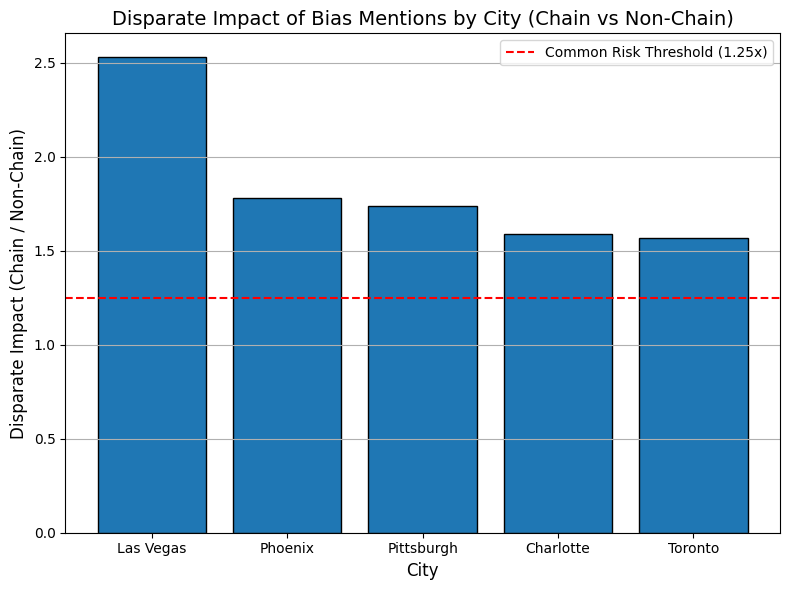

In [315]:
import matplotlib.pyplot as plt

# Sort cities by Disparate Impact
city_di_sorted = city_di_df.copy()
city_di_sorted = city_di_sorted[city_di_sorted['Disparate Impact'] != "Not enough flagged cases"]
city_di_sorted = city_di_sorted.sort_values('Disparate Impact', ascending=False)

# Plot
plt.figure(figsize=(8,6))
plt.bar(city_di_sorted['City'], city_di_sorted['Disparate Impact'], edgecolor='black')
plt.title('Disparate Impact of Bias Mentions by City (Chain vs Non-Chain)', fontsize=14)
plt.xlabel('City', fontsize=12)
plt.ylabel('Disparate Impact (Chain / Non-Chain)', fontsize=12)
plt.axhline(1.25, color='red', linestyle='--', label='Common Risk Threshold (1.25x)')
plt.legend()
plt.grid(axis='y')
plt.tight_layout()
plt.show()


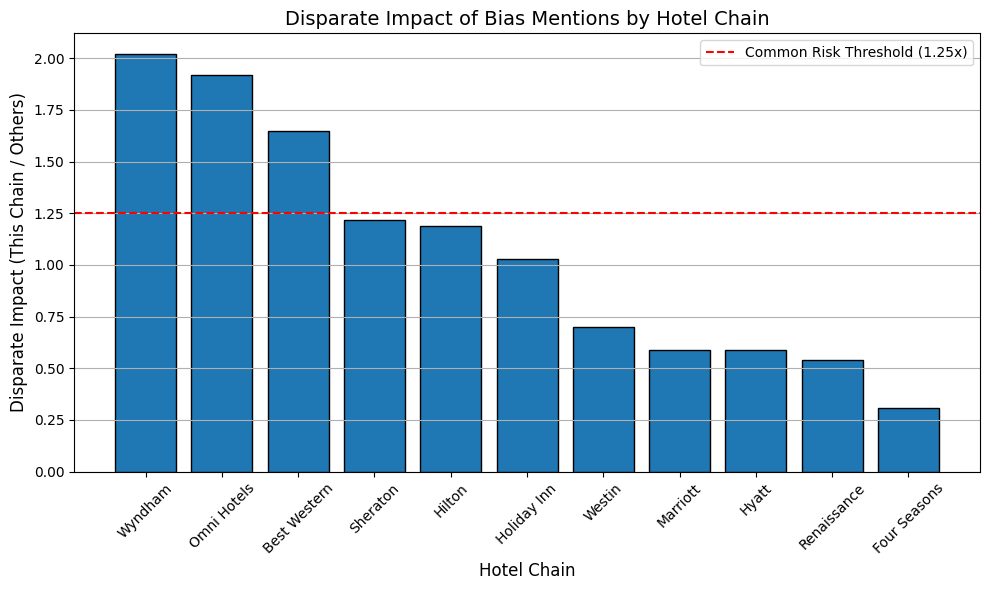

In [316]:
# Sort hotel chains by Disparate Impact
chain_di_sorted = chain_di_df.sort_values('Disparate Impact', ascending=False)

# Plot
plt.figure(figsize=(10,6))
plt.bar(chain_di_sorted['Hotel Chain'], chain_di_sorted['Disparate Impact'], edgecolor='black')
plt.title('Disparate Impact of Bias Mentions by Hotel Chain', fontsize=14)
plt.xlabel('Hotel Chain', fontsize=12)
plt.ylabel('Disparate Impact (This Chain / Others)', fontsize=12)
plt.axhline(1.25, color='red', linestyle='--', label='Common Risk Threshold (1.25x)')
plt.xticks(rotation=45)
plt.legend()
plt.grid(axis='y')
plt.tight_layout()
plt.show()


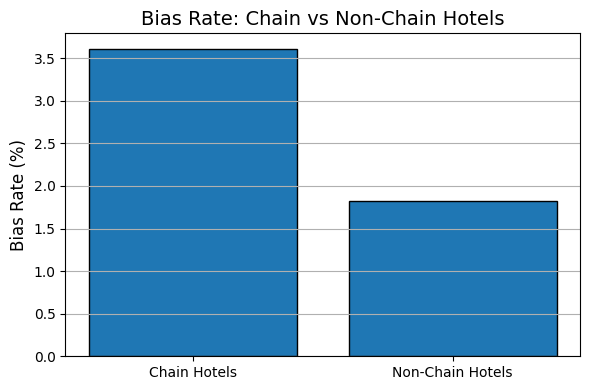

In [317]:
# Bar chart for chain vs non-chain bias rates
rates = [bias_rate_chain * 100, bias_rate_non_chain * 100]
labels = ['Chain Hotels', 'Non-Chain Hotels']

plt.figure(figsize=(6,4))
plt.bar(labels, rates, edgecolor='black')
plt.title('Bias Rate: Chain vs Non-Chain Hotels', fontsize=14)
plt.ylabel('Bias Rate (%)', fontsize=12)
plt.grid(axis='y')
plt.tight_layout()
plt.show()
